### 1. Задание модели среды

In [1]:
import numpy as np
from numpy import sin, cos, tan, arctan, arcsin, pi
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5) # это чтобы графики были большего размера. Можно параметры настроить под свой монитор

In [2]:
layers_vp = np.array([1450, 1806, 3359, 2811, 3147, 3787, 5081]).astype(float)
layers_rho = 0.31*layers_vp**0.25

layers_thk = np.array([76, 200,  309,  476,  696,  432, 100]).astype(float)
# layers_thk = np.array([500, 500,  500,  500,  600,  400, 100]).astype(float)
layers_de = np.array([0, 0.18, 0.046, 0.021, 0.152, 0.174, 0]).astype(float)
layers_ep = np.array([0, 0.145, 0.057, 0.033, 0.138, 0.243, 0]).astype(float)


Nlayers = len(layers_thk)


In [3]:
layers_timethk = 2000*layers_thk/layers_vp
depth = np.cumsum(layers_thk)
time = np.cumsum(layers_timethk)

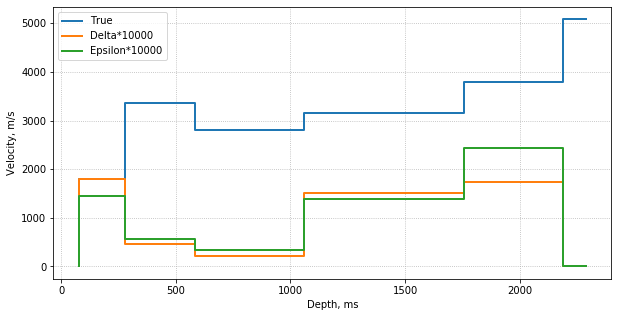

In [4]:
plt.step(depth, layers_vp, lw=2, label = 'True')
plt.step(depth, 10**4*layers_de, lw=2, label = 'Delta*10000')
plt.step(depth, 10**4*layers_ep, lw=2, label = 'Epsilon*10000')

plt.legend()
plt.xlabel('Depth, ms')
plt.ylabel('Velocity, m/s')
plt.grid(True, ls=':')
plt.show()


### 2. Трассирование лучей в изотропной модели


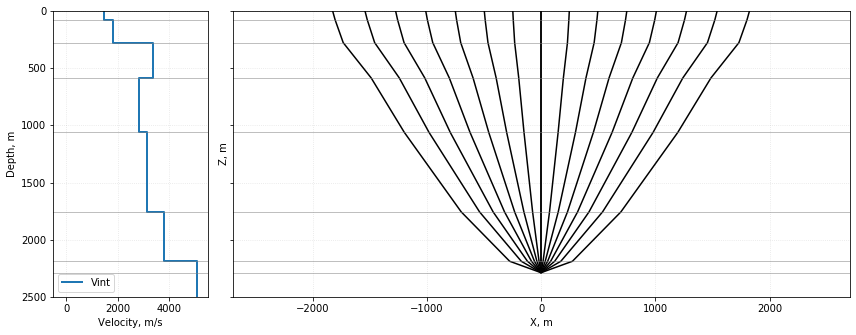

In [5]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=[12,8], sharey = True)

start_angle = pi*np.arange(0, 71, 10)/180.0

rays_x = np.zeros((len(start_angle), len(layers_thk)+1))
rays_t = np.zeros((len(start_angle), len(layers_thk)+1))
rays_th = np.zeros((len(start_angle), len(layers_thk)+1))


for ray_no, th0 in enumerate(start_angle):
    rays_th[ray_no, -1] = th0
#     print('ray {0}, start fi = {1}'.format(ray_no, th0))
#     print(rays_th[ray_no, :])
    for layer_no in np.arange(Nlayers)[::-1]:

        dz = layers_thk[layer_no]
        th_i = rays_th[ray_no, layer_no+1]
        dx = dz*tan(th_i)
        dt = dz/(layers_vp[layer_no] * cos(th_i))
#         print('  layer {0}. fi = {1}, vp = {2}, dx = {3}'.format(layer_no, th_i, layers_vp[layer_no], dx))
        rays_x[ray_no, layer_no] = rays_x[ray_no, layer_no+1] + dx
        rays_t[ray_no, layer_no] = rays_t[ray_no, layer_no+1] + dt
        if layer_no > 0:
            if np.abs(sin(th_i)*layers_vp[layer_no-1]/layers_vp[layer_no]) < 1:
                
                rays_th[ray_no, layer_no] = arcsin(sin(th_i)*layers_vp[layer_no-1]/layers_vp[layer_no])
            else:
                rays_th[ray_no, layer_no] = np.nan
    
    a1.plot(rays_x[ray_no, :], np.hstack((0, depth)), c = 'k')
    a1.plot(-rays_x[ray_no, :], np.hstack((0, depth)), c = 'k')


a1.set_xlabel('X, m')
a1.set_ylabel('Z, m')
a1.grid(True, ls=':', alpha = 0.35)


a0.step(np.hstack((layers_vp[0],layers_vp,layers_vp[-1])), np.hstack((0, depth,depth[-1]+200)), where='post', lw=2, label = 'Vint')

a0.legend()
a0.set_ylabel('Depth, m')
a0.set_xlabel('Velocity, m/s')
a0.grid(True, ls=':', alpha = 0.35)

a0.invert_yaxis()             
a1.set_aspect(1)
a0.set_xlim([-500,5500])
a0.set_ylim([2500,0])
a1.set_xlim([-2700,2700])
# a0.set_xlim([1000,5000])
# a0.set_ylim([2500,0])
# a1.set_ylim([2500,0])


for idpt in depth:
    a1.axhline(idpt, lw=1, c='grey', alpha=.5)
    a0.axhline(idpt, lw=1, c='gray', alpha=.5)
    

plt.tight_layout()

pos1 = a1.get_position(original=False)
pos0 = a0.get_position(original=False)

a0.set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])

plt.show()


### 3. Трассирование лучей в модели с учетом VTI

In [6]:
def vp_vti_weak(vp0, f, de, ep, ang): 
    return vp0*(1 + de*np.sin(ang)**2 + (ep-de)*np.sin(ang)**4)

def dvdth_weak(vp0, f, de, ep, ang0, dth = 1e-6):
    angles = np.array([ang0-dth, ang0+dth])
    return np.diff(vp_vti_weak(vp0, f, de, ep, angles))[0]/(2*dth)

def group_vel_weak(v_phase, th, vp0, f, de, ep):
    return v_phase*np.sqrt(1 +( (1/v_phase) * dvdth_weak(vp0, f, de, ep, th) )**2)

def group_angle_weak(v_phase, th_phase, vp0, f, de, ep):
    return arctan((tan(th_phase) + dvdth_weak(vp0, f, de, ep, th_phase)/v_phase)/(1-(tan(th_phase)/v_phase)*dvdth_weak(vp0, f, de, ep, th_phase)))


def compute_snell_vti(th_ph_1, v1, de1, ep1, v2, de2, ep2):

    f = 1-0.5**2

    v_ph_1 = vp_vti_weak(v1, f, de1, ep1, th_ph_1)

    fi_gr_1 = group_angle_weak(v_ph_1, th_ph_1, v1, f,de1,ep1)

    v_gr_1 = group_vel_weak(v_ph_1, th_ph_1, v1, f, de1, ep1)

    p_ray = sin(th_ph_1)/v_ph_1

    A4 = p_ray*v2*(ep2-de2)
    A3 = 0
    A2 = p_ray*v2*de2
    A1 = -1
    A0 = p_ray*v2
    th_ph_possible = np.roots([A4, A3, A2, A1, A0])
    th_poss_real = np.real(th_ph_possible)[np.isclose(th_ph_possible, np.real(th_ph_possible))]


    critical = len(th_poss_real[np.abs(th_poss_real)<1]) < 1
    if not critical:
        th_ph_2 = arcsin(th_poss_real[np.abs(th_poss_real)<1][0])
        v_ph_2 = vp_vti_weak(v2, f, de2, ep2, th_ph_2)

        fi_gr_2 = group_angle_weak(v_ph_2, th_ph_2, v2,f,de2,ep2)
        v_gr_2 = group_vel_weak(v_ph_2, th_ph_2, v2, f, de2, ep2)

    else:
        v_ph_2 = np.nan
        v_gr_2 = np.nan
        th_ph_2 = np.nan
        fi_gr_2 = np.nan
            
    return th_ph_2, v_ph_1, v_gr_1, fi_gr_1, fi_gr_2



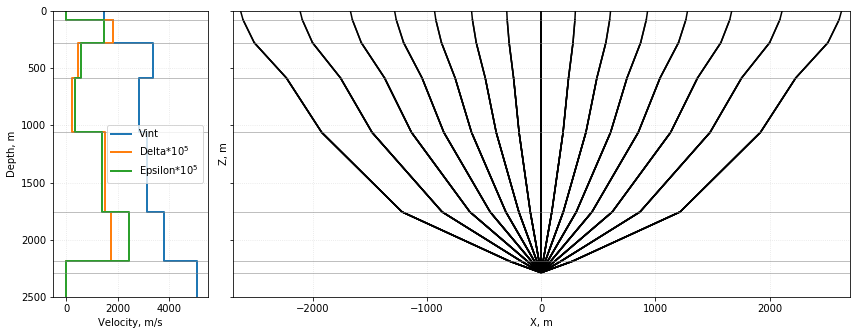

In [7]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=[12,8], sharey = True)

start_angle = pi*np.arange(0, 71, 10)/180.0

rani_x = np.zeros((len(start_angle), len(layers_thk)+1))*np.nan
rani_t = np.zeros((len(start_angle), len(layers_thk)+1))*np.nan
rani_th = np.zeros((len(start_angle), len(layers_thk)+1))*np.nan

rani_x[:,-1] = 0
rani_t[:,-1] = 0
rani_th[:,-1] = 0

for ray_no, th0 in enumerate(start_angle):
    rani_th[ray_no, -1] = th0

    for layer_no in np.arange(Nlayers)[::-1]:

        dz = layers_thk[layer_no]
        th_i = rani_th[ray_no, layer_no+1]
        
        v1 = layers_vp[layer_no]
        v2 = layers_vp[layer_no-1]
        de1 = layers_de[layer_no]
        de2 = layers_de[layer_no-1]        
        ep1 = layers_ep[layer_no]
        ep2 = layers_ep[layer_no-1]         

        if layer_no > -1:
            th_ph_2, v_ph_1, v_gr_1, fi_gr_1, fi_gr_2 = compute_snell_vti(th_i, v1, de1, ep1, v2, de2, ep2)
            rani_th[ray_no, layer_no] = th_ph_2

    
            dx = dz*tan(fi_gr_1)
            dt = dz/(v_gr_1 * cos(fi_gr_1))
    #         print('  layer {0}. fi = {1}, vp = {2}, dx = {3}'.format(layer_no, th_i, layers_vp[layer_no], dx))
            rani_x[ray_no, layer_no] = rani_x[ray_no, layer_no+1] + dx
            rani_t[ray_no, layer_no] = rani_t[ray_no, layer_no+1] + dt
        else:
            rani_th[ray_no, layer_no] = np.nan
        
        a1.plot(rani_x[ray_no, :], np.hstack((0, depth)), c = 'k')
        a1.plot(-rani_x[ray_no, :], np.hstack((0, depth)), c = 'k')


a1.set_xlabel('X, m')
a1.set_ylabel('Z, m')
a1.grid(True, ls=':', alpha = 0.35)


a0.step(np.hstack((layers_vp[0],layers_vp,layers_vp[-1])), np.hstack((0, depth,depth[-1]+200)), where='post', lw=2, label = 'Vint')
a0.step(10**4*np.hstack((layers_de[0],layers_de,layers_de[-1])), np.hstack((0, depth,depth[-1]+200)), where='post', lw=2, label = 'Delta*$10^5$')
a0.step(10**4*np.hstack((layers_ep[0],layers_ep,layers_ep[-1])), np.hstack((0, depth,depth[-1]+200)), where='post', lw=2, label = 'Epsilon*$10^5$')


a0.legend()
a0.set_ylabel('Depth, m')
a0.set_xlabel('Velocity, m/s')
a0.grid(True, ls=':', alpha = 0.35)

for idpt in depth:
    a1.axhline(idpt, lw=1, c='grey', alpha=.5)
    a0.axhline(idpt, lw=1, c='gray', alpha=.5)
    
a0.invert_yaxis()             
a1.set_aspect(1)
a0.set_xlim([-500,5500])
a0.set_ylim([2500,0])
a1.set_xlim([-2700,2700])

plt.tight_layout()

pos1 = a1.get_position(original=False)
pos0 = a0.get_position(original=False)

a0.set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])

plt.show()

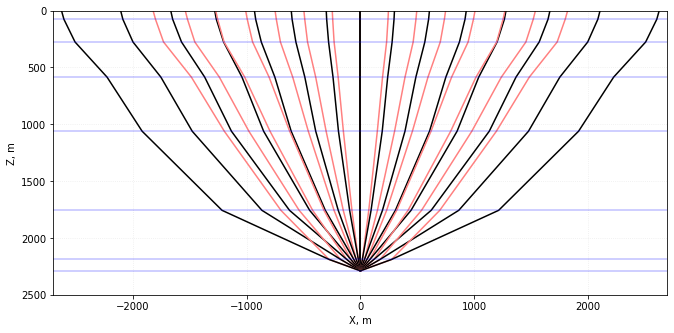

In [8]:
f, ax2 = plt.subplots(figsize=[11,8])
a2=ax2

for ray_no, th0 in enumerate(start_angle):
    a2.plot(rays_x[ray_no, :], np.hstack((0, depth)), c = [1,0.5,0.5])
    a2.plot(-rays_x[ray_no, :], np.hstack((0, depth)), c = [1,0.5,0.5])
    a2.plot(rani_x[ray_no, :], np.hstack((0, depth)), c = 'k')
    a2.plot(-rani_x[ray_no, :], np.hstack((0, depth)), c = 'k')
    
for idpt in depth:
    a2.axhline(idpt, lw=1.5, c='blue', alpha=.25)
    
a2.set_xlabel('X, m')
a2.set_ylabel('Z, m')
a2.grid(True, ls=':', alpha = 0.25)

a2.set_aspect(1)

a2.set_ylim([2500,0])
a2.set_xlim([-2700,2700])

plt.show()

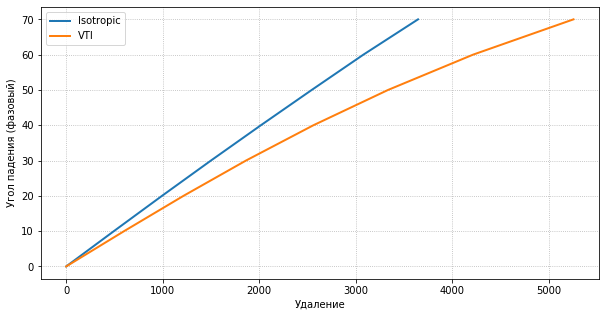

In [9]:
plt.plot(2*rays_x[:,0], 180*start_angle/pi, lw = 2, label = 'Isotropic')
plt.plot(2*rani_x[:,0], 180*start_angle/pi, lw = 2, label = 'VTI')

plt.legend()
plt.grid(True, ls=':')
plt.ylabel('Угол падения (фазовый)')
plt.xlabel('Удаление')
plt.show()